# Coding Assignment - 1

In [663]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import linear_model as lm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.random.seed(100)


## Part 1: Generate Data

Generate the 20 centers, 10 for each group.

<span style="color:red">To Be Done : </span> Make the Centers created based on the formula provided in the problem statement

In [2]:
csize = 5      
p = 2      
s = 1;      # sd for generating the centers within each class                    
m1 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[0, 1]] * csize)])

Generate training & test data.

In [3]:
n = 5
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n)
id0 = np.random.randint(csize, size = n)

# sd for generating data  
s = np.sqrt(float(1)/5) 

traindata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
ytrain = np.concatenate(([1]*n, [0]*n))

In [11]:
N = 5
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = N)
id0 = np.random.randint(csize, size = N)

# sd for generating data  
s = np.sqrt(float(1)/5) 

testdata = np.random.normal(size = (2 * N, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
ytest = np.concatenate(([1]*N, [0]*N))

Visulization

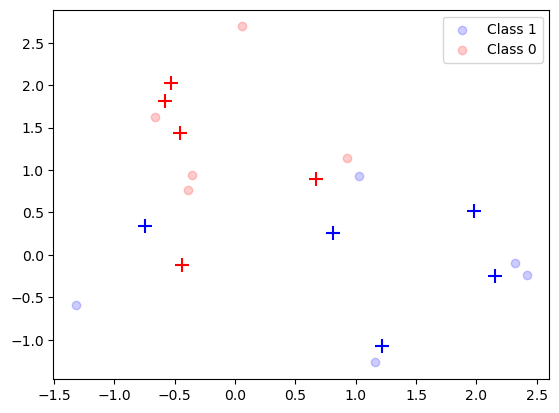

In [4]:
plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

In [5]:
id1 = np.random.randint(csize, size = n)


In [6]:
id1

array([0, 2, 2, 3, 4])

In [7]:
np.random.seed(100)

np.random.normal(loc=[1,1,1], scale=1)

array([-0.74976547,  1.3426804 ,  2.1530358 ])

## Part 2: kNN

### 2.1 kNN implementation from scratch, with handling for Distance ties & Voting ties

In [651]:
# Final

def eucledian_distance(A, B):
    M = A.shape[0]
    N = B.shape[0]
    
    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    
    D_squared =  A_dots + B_dots -2*A.dot(B.T)
    
    return D_squared
    
def custom_knn(train_data, test_data, ytrain, k):
    distance_matrix = eucledian_distance(test_data, train_data)
    
    top_k_indices = np.argsort(distance_matrix, axis=1)
    ytest_pred = ytrain[top_k_indices]
    voting_ties_ytest_pred = np.copy(ytest_pred)
    
    """
    Prepare the Distance Matrix for kNN
    Identify the top k points
    
    Distance Ties: For those k points that have distance ties & falling outside of k. 
    Include them as well for computing Nearest Neighbor.
    This would mean, we are using k or more points for prediction
    
    Mask rest of the points, outside of k, in the distance matrix, by setting it as NaN.
    """
    kth_distance = np.sort(distance_matrix)[:, k-1]
    distance_matrix = np.where((distance_matrix <= np.transpose([kth_distance])), distance_matrix, np.nan)
    distance_matrix = np.sort(distance_matrix)
    
    """
    Voting ties : 
    Prepare a Distance matrix with one Neighbor less (k-1), by masking the last of k-neighbor as NaN.
    """
    voting_ties_distance_matrix = np.copy(distance_matrix)
    voting_ties_distance_matrix[:, np.nanargmax(voting_ties_distance_matrix, axis=1) ] = np.nan
    
    """
    Count the predictions & choose the majority as the predicted value
    """
    ytest_pred = ytest_pred * (distance_matrix + 0.1)
    
    ytest_pred_0_count = np.count_nonzero(ytest_pred == 0, axis = 1)
    ytest_pred_1_count = np.count_nonzero(ytest_pred > 0, axis = 1)
    
    ytest_pred = ytest_pred_1_count > ytest_pred_0_count
    ytest_pred = ytest_pred.astype(int)
    
    """
    Predict with Voting Ties Distance Matrix
    """
    voting_ties_ytest_pred = voting_ties_ytest_pred * (voting_ties_distance_matrix + 0.1)
    
    voting_ties_ytest_pred_0_count = np.count_nonzero(voting_ties_ytest_pred == 0, axis = 1)
    voting_ties_ytest_pred_1_count = np.count_nonzero(voting_ties_ytest_pred > 0, axis = 1)
    
    voting_ties_ytest_pred = voting_ties_ytest_pred_1_count > voting_ties_ytest_pred_0_count
    voting_ties_ytest_pred = voting_ties_ytest_pred.astype(int)
    
    """
    Prepare the final prediction by merging the predicted values, with the Voting tie predictions 
    for the ones that have voting ties
    """
    ytest_pred_mask = (ytest_pred_1_count == ytest_pred_0_count)
    final_ytest_pred = np.ma.sum([np.ma.array([ytest_pred], mask=ytest_pred_mask), np.ma.array([voting_ties_ytest_pred], mask=np.invert(ytest_pred_mask))], axis=0)
    
    return final_ytest_pred.flatten()



### 2.2 Distance Ties & Voting ties

<b>Distance Ties:</b>

<li>After selecting k nearest neighbors, if there are still points outside of k, with the same distance.
<li>Include those points as well, for computing Nearest Neighbor.
<li>This would mean, we are using k or more points for prediction

<b>Voting Ties:</b>

<li> Voting tie can be handled by having the farthest neighbor among k, removed from voting process.
<li> With one less neighbor, tie is guaranteed to be breaken.
<li> Now, select the majority value as prediction.


### 2.3 Testing

<li>Tested & Compared the predicted results of Custom kNN & sklearn version.
<li> Predicted values & Confusion matrix generated for both the versions looks similar.

In [675]:
myk = [5, 3, 1]

train_err_knn = []
test_err_knn = []

for k in myk:
    myknn = knn(n_neighbors = k)
    myknn.fit(traindata, ytrain)
    ytest_pred_sk = myknn.predict(testdata)
    cm_sk = confusion_matrix(ytest_pred_sk, ytest)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm_sk)
#     disp.plot()
    ytest_pred_cm = custom_knn(traindata, testdata, ytrain, k)
    cm_cm = confusion_matrix(ytest_pred_cm, ytest)
    print("k=" + str(k))
    print("ytest=" + str(ytest))
    print("ytest_pred_sk=" + str(ytest_pred_sk))
    print("ytest_pred_cm=" + str(ytest_pred_cm))
    print("cm_sk \n" + str(cm_sk))
    print("cm_cm \n" + str(cm_cm))
    print("---------------------")
    
#     train_err_knn.append(1 - myknn.score(traindata, ytrain))
#     test_err_knn.append(1- myknn.score(testdata, ytest))

k=5
ytest=[1 1 1 1 1 0 0 0 0 0]
ytest_pred_sk=[0 1 1 1 1 0 0 0 1 0]
ytest_pred_cm=[0 1 1 1 1 0 0 0 1 0]
cm_sk 
[[4 1]
 [1 4]]
cm_cm 
[[4 1]
 [1 4]]
---------------------
k=3
ytest=[1 1 1 1 1 0 0 0 0 0]
ytest_pred_sk=[0 1 1 1 1 0 0 0 0 0]
ytest_pred_cm=[0 1 1 1 1 0 0 0 0 0]
cm_sk 
[[5 1]
 [0 4]]
cm_cm 
[[5 1]
 [0 4]]
---------------------
k=1
ytest=[1 1 1 1 1 0 0 0 0 0]
ytest_pred_sk=[1 1 1 1 1 0 0 0 1 0]
ytest_pred_cm=[1 1 1 1 1 0 0 0 1 0]
cm_sk 
[[4 0]
 [1 5]]
cm_cm 
[[4 0]
 [1 5]]
---------------------
